# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /content/drive/My Drive/cs445_projects/proj2/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj2/samples: No such file or directory


In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [38]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    H, W = sample.shape[:2]
    num_patches = out_size // patch_size

    if sample.ndim == 3:
        output = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    else:
        output = np.zeros((out_size, out_size), dtype=sample.dtype)

    for i in range(num_patches):
        for j in range(num_patches):
            y = np.random.randint(0, H - patch_size + 1)
            x = np.random.randint(0, W - patch_size + 1)
            patch = sample[y:y + patch_size, x:x + patch_size]
            output[i * patch_size:(i + 1) * patch_size,
                   j * patch_size:(j + 1) * patch_size] = patch

    return output


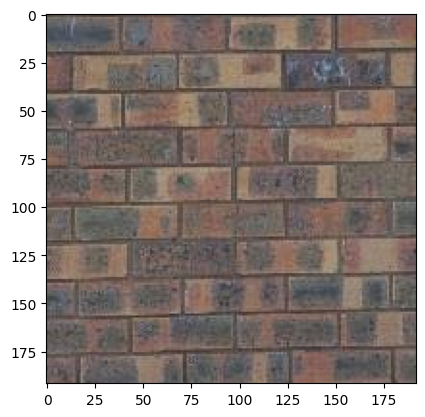

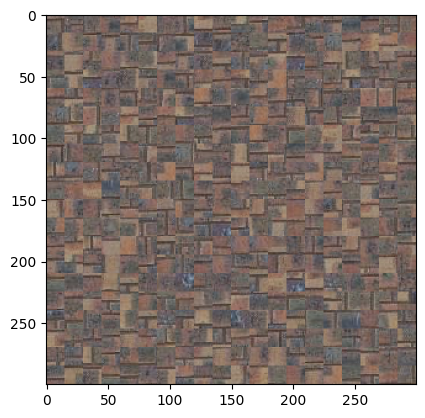

In [39]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB).astype(np.float64)/255.0

plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

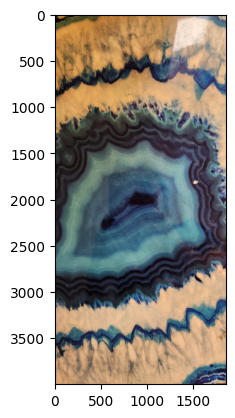

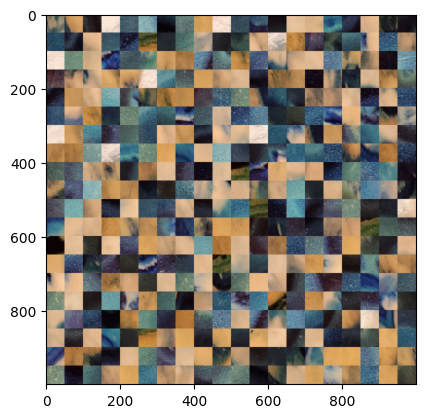

In [40]:
# Applying quilt_random to my own images (1)
sample_img_fn = 'my_images/1000047437.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB).astype(np.float64)/255.0
plt.imshow(sample_img)
plt.show()

out_size = 1000  # change these parameters as needed
patch_size = 50
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

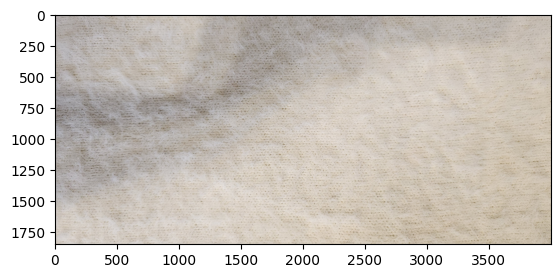

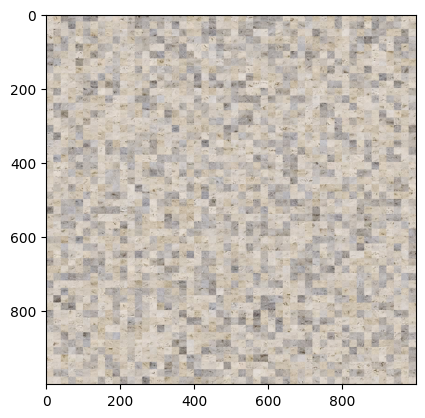

In [41]:
# Applying quilt_random to my own images (2)
sample_img_fn = 'my_images/1000047455.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB).astype(np.float64)/255.0
plt.imshow(sample_img)
plt.show()

out_size = 1000  # change these parameters as needed
patch_size = 20
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

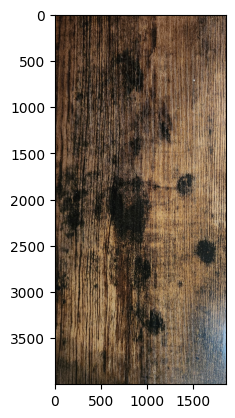

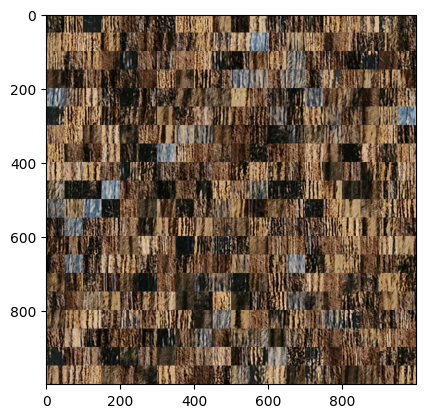

In [42]:
# Applying quilt_random to my own images (3)
sample_img_fn = 'my_images/1000047464.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB).astype(np.float64)/255.0
plt.imshow(sample_img)
plt.show()

out_size = 1000  # change these parameters as needed
patch_size = 50
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [ ]:
def ssd_patch(template_patch, mask, sample_patch):
    """
    Compute SSD cost map for every possible patch position in the sample image.
    Uses efficient filtering: ssd = sum((M*T)^2) - 2*filter2D(I, M*T) + filter2D(I^2, M)

    :param template: numpy.ndarray  patch from output image (patch_size x patch_size [x C])
    :param mask: numpy.ndarray      binary mask (patch_size x patch_size), 1 in overlap region
    :param sample: numpy.ndarray    input texture image (H x W [x C]), float
    :return: numpy.ndarray          cost image (H x W)
    """
    ps = template_patch.shape[0]
    half = ps // 2
    H, W = sample_patch.shape[:2]

    if sample_patch.ndim == 2:
        sample_patch = sample_patch[:, :, np.newaxis]
        template_patch = template_patch[:, :, np.newaxis]

    C = sample_patch.shape[2]
    cost = np.zeros((H, W), dtype=np.float64)

    for c in range(C):
        T = template_patch[:, :, c]
        I_ch = sample_patch[:, :, c]
        MT = mask * T

        term1 = np.sum(MT ** 2)
        term2 = cv2.filter2D(I_ch, ddepth=-1, kernel=MT)
        term3 = cv2.filter2D(I_ch ** 2, ddepth=-1, kernel=mask)

        cost += term1 - 2.0 * term2 + term3

    maxval = cost.max() + 1
    if half > 0:
        cost[:half, :] = maxval
        cost[-half:, :] = maxval
        cost[:, :half] = maxval
        cost[:, -half:] = maxval

    return cost
    

In [51]:
def choose_sample(cost, tol):
    """
    Select a random patch position among the tol lowest-cost candidates.

    :param cost: numpy.ndarray   cost image (H x W)
    :param tol: int              number of lowest-cost candidates to sample from
    :return: tuple               (row, col) of selected patch center
    """
    indices = np.argsort(cost, axis=None)
    choice = int(random() * tol)
    idx = indices[choice]
    return np.unravel_index(idx, cost.shape)

In [52]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Quilts an output image by sampling overlapping patches with low SSD cost.

    :param sample: numpy.ndarray   input texture image
    :param out_size: int           width/height of square output image
    :param patch_size: int         width/height of square patch (use odd values)
    :param overlap: int            number of overlapping pixels between adjacent patches
    :param tol: int                number of lowest-cost candidates to randomly sample from
    :return: numpy.ndarray
    """

    H, W = sample.shape[:2]
    half = patch_size // 2
    step = patch_size - overlap

    num_patches = int(np.ceil((out_size - patch_size) / step)) + 1
    actual_out = patch_size + (num_patches - 1) * step

    if sample.ndim == 3:
        output = np.zeros((actual_out, actual_out, sample.shape[2]), dtype=np.float64)
    else:
        output = np.zeros((actual_out, actual_out), dtype=np.float64)

    for i in range(num_patches):
        for j in range(num_patches):
            out_r = i * step
            out_c = j * step

            if i == 0 and j == 0:
                y = np.random.randint(0, H - patch_size + 1)
                x = np.random.randint(0, W - patch_size + 1)
                output[out_r:out_r+patch_size, out_c:out_c+patch_size] = \
                    sample[y:y+patch_size, x:x+patch_size].copy()
                continue

            mask = np.zeros((patch_size, patch_size), dtype=np.float64)
            if i > 0:
                mask[:overlap, :] = 1.0
            if j > 0:
                mask[:, :overlap] = 1.0

            template = output[out_r:out_r+patch_size, out_c:out_c+patch_size].copy()

            cost = ssd_patch(template, mask, sample)

            r, c = choose_sample(cost, tol)

            in_r = r - half
            in_c = c - half
            output[out_r:out_r+patch_size, out_c:out_c+patch_size] = \
                sample[in_r:in_r+patch_size, in_c:in_c+patch_size].copy()

    return output[:out_size, :out_size].astype(sample.dtype)

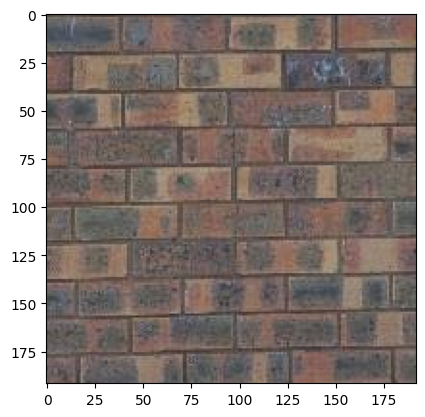

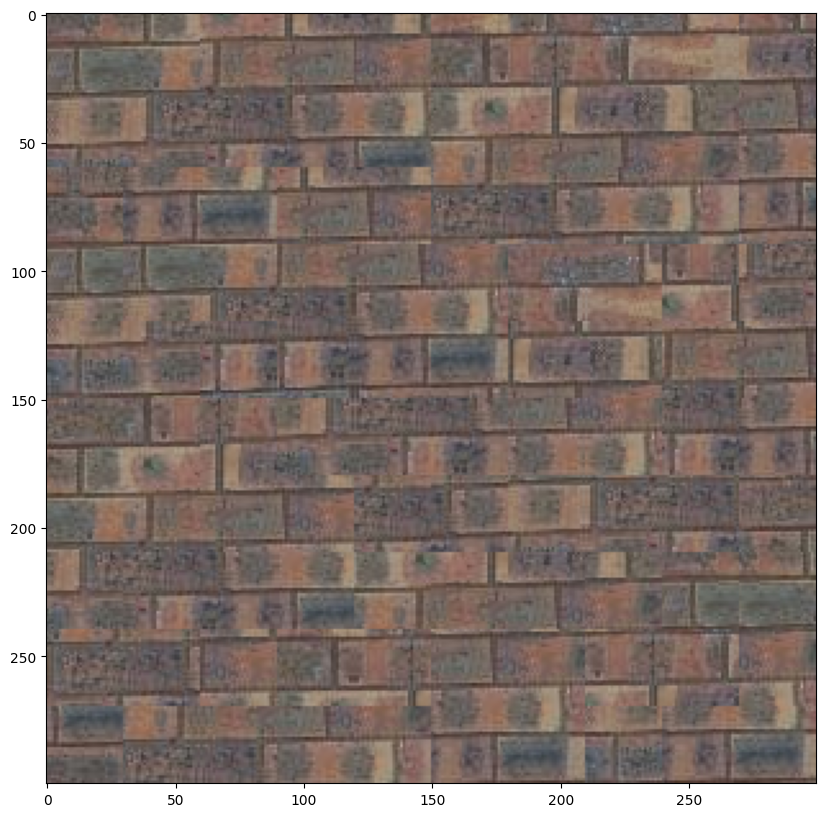

In [70]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB).astype(np.float64)/255.0
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 50
overlap = 20
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [ ]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [ ]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """


In [ ]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """


In [ ]:
# load/process appropriate input texture and guidance images

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).